In [1]:
"""
Prediction file: Based on the trained neural network,see the performace on the testing set
Mapping Sim1->Sim 2 (Fig 3)

General workflow
Load test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> 
Decode into higher dimensional representation using SD VAE-> Display 


Note: This file has issues with loading both the pre-trained VAE and the trained model together with gpu.
One temporary fix I do is I encode the images using a CPU, but it takes a lot of time. 
In model training, the encoding of the outputs is done in a seperate script using a seperate GPU, and saved as a pickle file. 
In the training script, the latents are loaded from a pickle file. 
"""

'\nPrediction file: Based on the trained neural network,see the performace on the testing set\nMapping Sim1->Sim 2 (Fig 3)\n\nGeneral workflow\nLoad test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> \nDecode into higher dimensional representation using SD VAE-> Display \n\n\nNote: This file has issues with loading both the pre-trained VAE and the trained model together with gpu.\nOne temporary fix I do is I encode the images using a CPU, but it takes a lot of time. \nIn model training, the encoding of the outputs is done in a seperate script using a seperate GPU, and saved as a pickle file. \nIn the training script, the latents are loaded from a pickle file. \n'

In [2]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from PIL import Image


from models.vae import vae, encode_img,decode_img
from models.dilResNet import PDEArenaDilatedResNet
import pickle

from utils.config import EXPERIMENTAL_TRAIN_OUTPUT_FOLDER, SIMULATION_CORRTOEXP_TRAIN_OUTPUT_FOLDER
from utils.config import LATENT_OUTPUT_SIMULATION_CORRTOEXP_SAVED,MODEL_DILRESNET_SUPPFIG13, SORTED_FILENAMES_PATH
from utils.config import SIMULATED_FOLDER,EXPERIMENTAL_FOLDER

from utils.display import display_predicted_images, display_images_with_ssim, display_predicted_images_5X
from utils.preprocess import preprocess_simulation_input_data,preprocess_simulation_output_data,scale_latents,preprocess_experimental_output_data,preprocess_experimental_output_data_rawfiles



/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:

'''
Loading test data for model testing

'''

# note the weird naming is because the same files served as output in Fig 2, but now are input

path_input=SIMULATION_CORRTOEXP_TRAIN_OUTPUT_FOLDER
path_output=EXPERIMENTAL_TRAIN_OUTPUT_FOLDER

####################

### MODIFIED 070924
# Implemented sorting to sort files in a specific order- image with all rotations first and then the second images and rotations

def load_sorted_filenames(file_path):
    with open(file_path, 'r') as file:
        sorted_filenames = [line.strip() for line in file.readlines()]
    return sorted_filenames

##################

# The network was only trained till 30k indices, so we are testing on others
# the 1000 differences are because of data augmentation samples in between 
desired_indices = [30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]
img_filenames=load_sorted_filenames(SORTED_FILENAMES_PATH)
img_filenames=[img_filenames[i] for i in desired_indices]

# output data
start_index = 0  
end_index = len(desired_indices)

# here the simulation serves as the input data
input_data=preprocess_simulation_output_data(path_input, start_index, end_index, img_filenames)

# experiments BnW is the output data
output_data=preprocess_experimental_output_data(path_output, start_index, end_index, img_filenames)

## add some of the images from the main dataset that hasn't been used to train the network 

X=input_data
y=output_data


# size of input data is 32x32 and output data is 256x256
X=(np.array(X).reshape(-1,1,256,256)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,256,256)) #/255.0


# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)



In [3]:
type(img_filenames)

list

In [4]:

'''
Defining dilResNet model for loading model weights
'''

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels (e.g., RGB image)
    out_channels=4,              # Output channels (e.g., RGB image or latent channels)
    hidden_channels=64,          # Number of hidden channels
    num_blocks=18,               # Number of dilated blocks (similar to number of ResNet blocks)
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)



In [5]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
dilResnet will predict latent representation of patterns

The difference here compared to training seed to simulation is that the input also needs to be encoded before
being supplied as input to the network-- this is the memory bottleneck

'''
# implement batches procedure to avoid OOMs

device =torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoded_latents = []

# encode latent of intermeditate test  images
# do in batches to avoid OOMs

batch_size = 8  
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    latent = encode_img(batch)
    encoded_latents.append(latent.cpu())

# encoded_latents_squeezed=[t.squeeze(0) for t in encoded_latents]
# stacked_tensor = torch.stack(encoded_latents_squeezed, dim=0)

# Simulating input image data as a list of random torch tensors
# input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
# image_np_input = np.concatenate(input_images_list, axis=0)


# image_input=torch.tensor(image_np_input)

image_np_input = torch.cat(encoded_latents, dim=0).numpy()
image_input=torch.tensor(image_np_input)

model.load_state_dict(torch.load(MODEL_DILRESNET_SUPPFIG13))
model.to(device)

model.eval()



with torch.no_grad():
    predicted_latents=model(image_input.to(device))   #y3   stacked_tensor is the input seed with 3 channels for the UNET

predicted_latents_rescaled=predicted_latents

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents_rescaled.cpu())   #  Note the .cpu()

# for generation see first row seed, second row final patterns, third row generated patterns


In [21]:
# Convert tensor to grayscale using cv2.cvtColor and keep as tensor
# Convert to numpy for cv2 processing, then back to tensor
pred_images_numpy = pred_images.cpu().numpy().transpose(0, 2, 3, 1) * 255.0  # Convert to HWC format and scale to 0-255
pred_images_gray_list = []

for i in range(pred_images_numpy.shape[0]):
    gray_img = cv2.cvtColor(pred_images_numpy[i].astype(np.uint8), cv2.COLOR_RGB2GRAY)
    pred_images_gray_list.append(gray_img)

# Convert back to tensor format (NCHW)
pred_images_gray = torch.tensor(np.stack(pred_images_gray_list)).unsqueeze(1).float() / 255.0

# Check the shape of the grayscale tensor
pred_images_gray.shape

torch.Size([10, 1, 256, 256])

/tmp/ipykernel_901209/438492154.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_images_tensor=torch.tensor(pred_images_gray).unsqueeze(1)/255.0


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


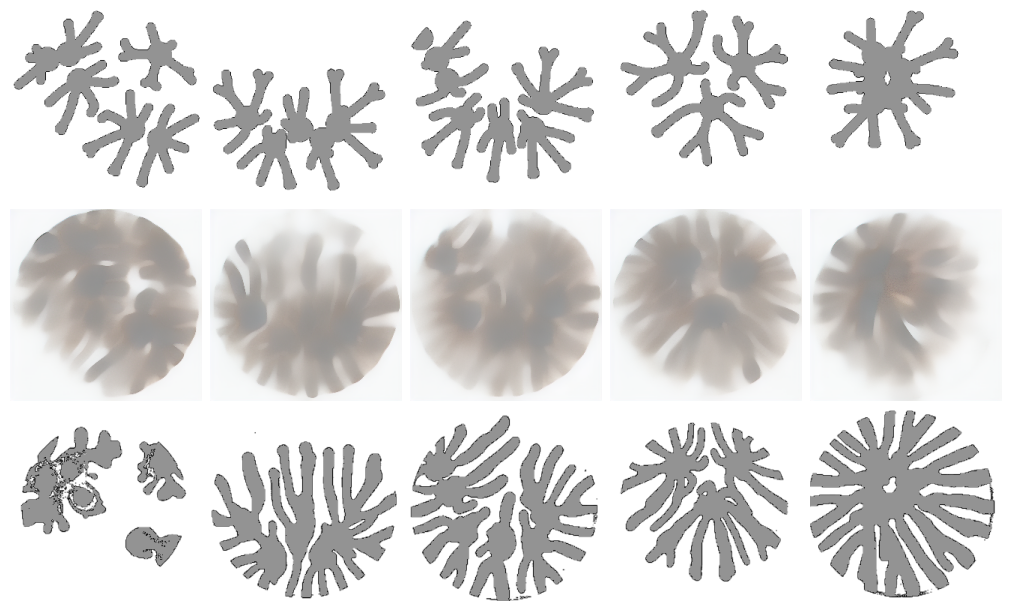

In [23]:
'''
Displaying simulation 1, actual simulation 2 and predicted simulation 2

For reference, simulation 1 is from the "intermediate" folder and simulation 2 is from the "complex" folder. simulation 1 is also
the default sim configuration. 

'''


selected_indices=[3,4,6,7,8] 
# Display samples from train dataset
order=[0,2,1]

# convert predicted images to greyscale for display


# convert back to tensor
pred_images_tensor=torch.tensor(pred_images_gray).unsqueeze(1)/255.0

# y_gray=process_tensor_batch_with_grayfordisplay(y,img_length=256,img_width=256,img_type='sim')
# X_gray=process_tensor_batch_with_grayfordisplay(X,img_length=256,img_width=256,img_type='sim')
# pred_images_gray=process_tensor_batch_with_grayfordisplay(pred_images,img_length=256,img_width=256,img_type='sim')


display_predicted_images(X[selected_indices],y[selected_indices], pred_images[selected_indices] ,5, order=order)   #
    
# selected_indices = [4, 5, 2, 10, 14]
# # Display samples from train dataset
# display_predicted_images(X[selected_indices],y[selected_indices], pred_images[selected_indices] ,5)   # 

Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


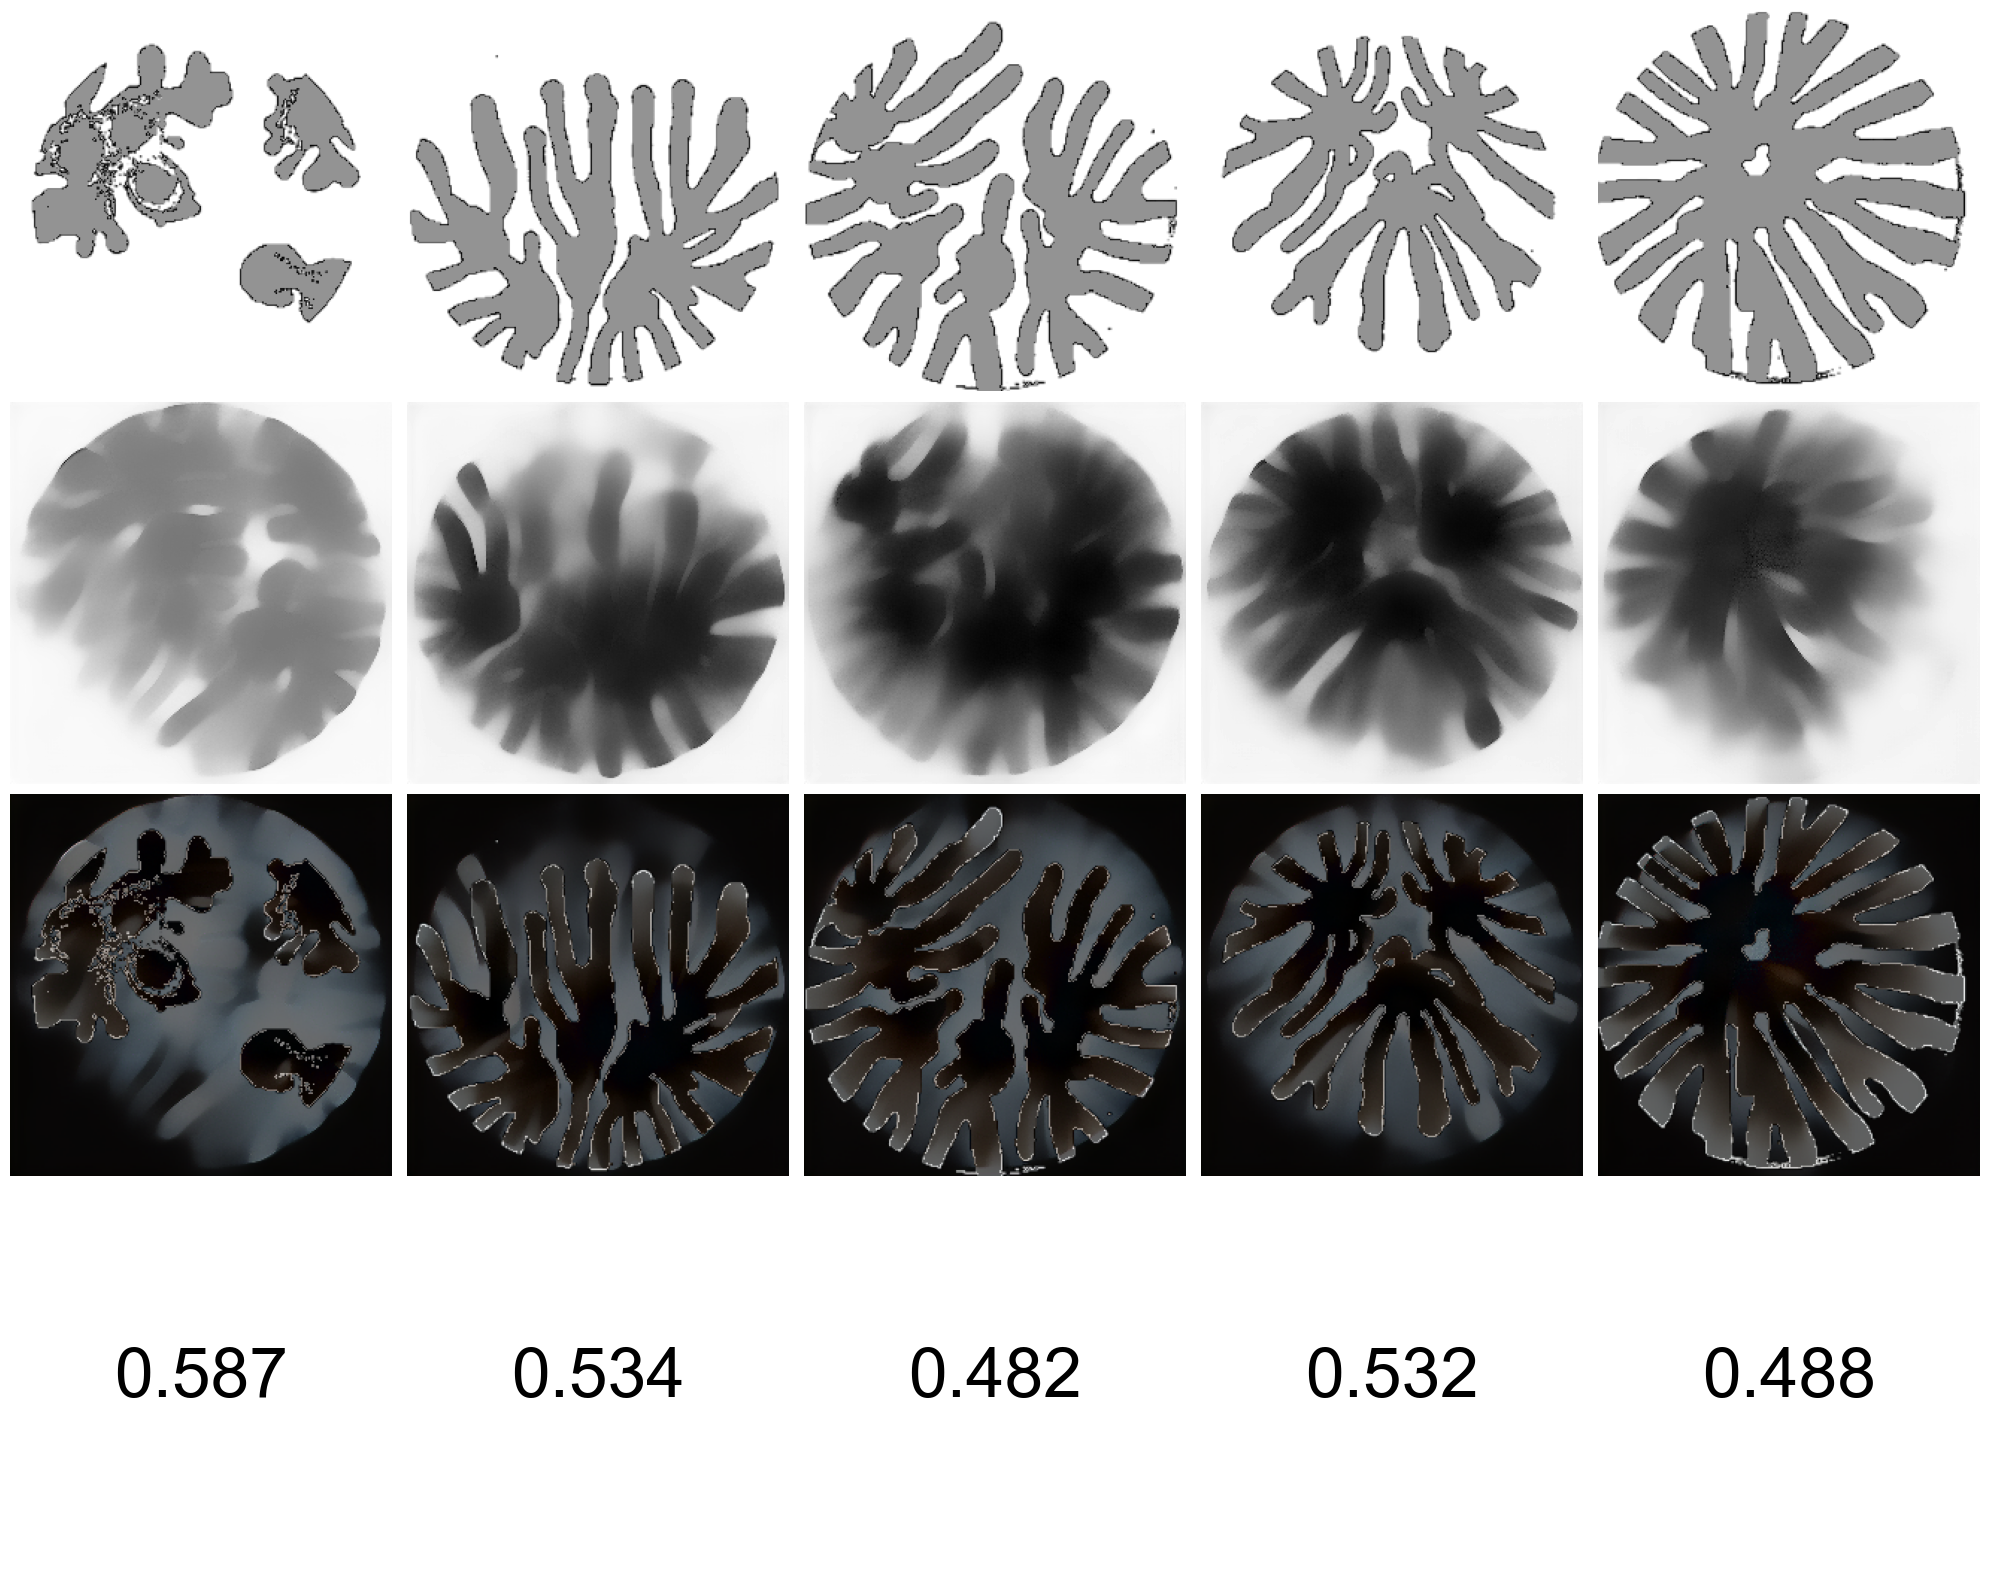

In [ ]:
'''
Results represent images that have similar number of seeds as training set, but spatial positioning is different
'''
# note the visual differences are due to conversion to grayscale for ssim calculation

# Assuming X and pred_images are already defined
display_images_with_ssim(y[selected_indices], pred_images[selected_indices], num_samples=5) 

### The following is for seeing the performance on training/validation images for a baseline of how the network is doing. This is done for now by loading images that are in the training set, and applying the final prediction model on that set. Will have to improve this later like seeing the performance in training by using lightning or tensorboard

In [8]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
import pickle

In [25]:
'''
Loading from training data 
'''

# note the weird naming is because the same files served as output in Fig 2, but now are input

path_input=SIMULATION_CORRTOEXP_TRAIN_OUTPUT_FOLDER
path_output=EXPERIMENTAL_TRAIN_OUTPUT_FOLDER

####################

### MODIFIED 070924
# Implemented sorting to sort files in a specific order- image with all rotations first and then the second images and rotations

def load_sorted_filenames(file_path):
    with open(file_path, 'r') as file:
        sorted_filenames = [line.strip() for line in file.readlines()]
    return sorted_filenames

##################

# The network was only trained till 30k indices, so using those indices here 
desired_indices = [10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100]
img_filenames=load_sorted_filenames(SORTED_FILENAMES_PATH)
img_filenames=[img_filenames[i] for i in desired_indices]

# output data
start_index = 0  
end_index = len(desired_indices)

# here the simulation serves as the input data
input_data=preprocess_simulation_output_data(path_input, start_index, end_index, img_filenames)

# experiments BnW is the output data
output_data=preprocess_experimental_output_data(path_output, start_index, end_index, img_filenames)

## add some of the images from the main dataset that hasn't been used to train the network 

X=input_data
y=output_data


# size of input data is 32x32 and output data is 256x256
X=(np.array(X).reshape(-1,1,256,256)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,256,256)) #/255.0


# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

In [26]:

# Define the dilResNet model
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=18,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8],   # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


In [38]:
'''
Since we are dealing with training dataset, the latents for simulation input have already been encoded and saved as pickle files
Here we just load them from the pickle files
'''

# Import the correct latent file path


pickle_in=open(LATENT_OUTPUT_SIMULATION_CORRTOEXP_SAVED,"rb")  # Use the correct latent file
yprime=pickle.load(pickle_in)

# select only the required indices from the loaded data
# Since latents were encoded for the entire dataset in sequential order,
# we need to use the same desired_indices that were used for loading images
yprime = yprime[desired_indices, :, :, :]

yprime=torch.Tensor(yprime)


yprime_scaled=scale_latents(yprime)
yprime_scaled=yprime_scaled.float()

In [40]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vae.to(device) # now put on gpu


model.load_state_dict(torch.load(MODEL_DILRESNET_SUPPFIG13))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(yprime.to(device))  #y3 is the input seed with 3 channels for the UNET 


predicted_latents_rescaled=scale_latents(predicted_latents)

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


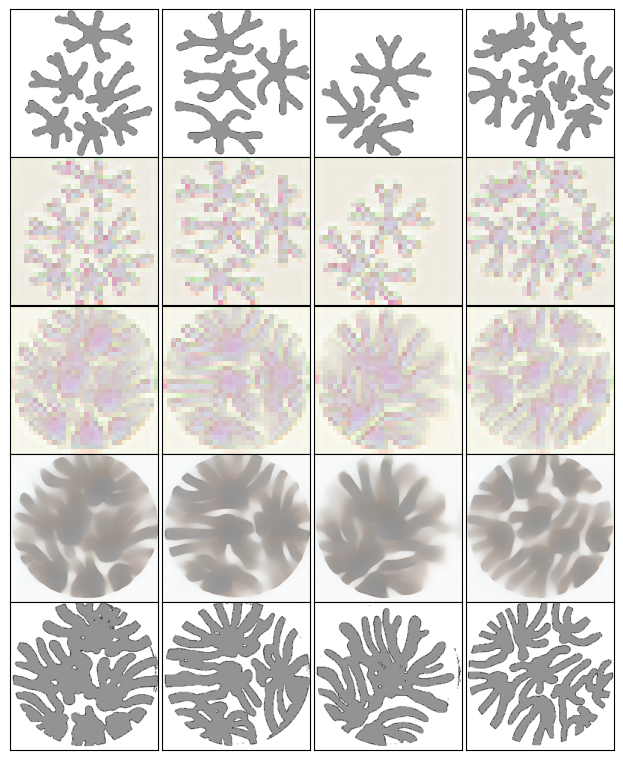

In [41]:
'''
Displaying simulation 1, latent simulation 1, predicted latent simulation 2, predicted simulation 2 and actual simulation 2

For reference, simulation 1 is from the "intermediate" folder and simulation 2 is from the "complex" folder. simulation 1 is also
the default sim configuration. 

'''

# Display samples from train dataset

display_predicted_images_5X(X,yprime_scaled,predicted_latents_rescaled,pred_images,y ,4) # 


### This part tries to test whether we are predicting the average of the experimental replicates, as it could be one of the reasons why the image is a blur. 

Processed 6 images


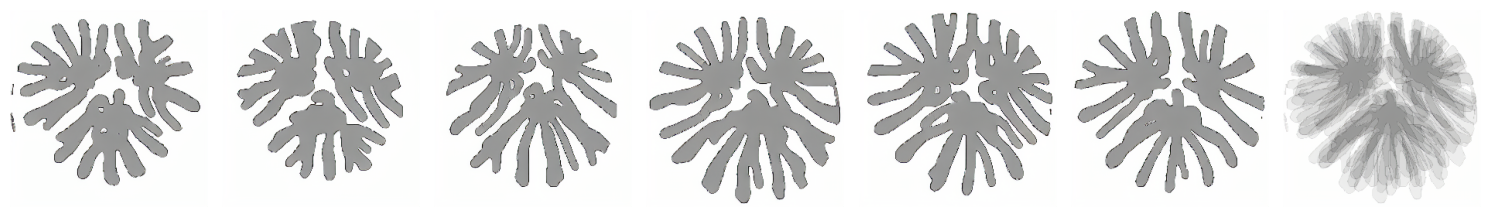

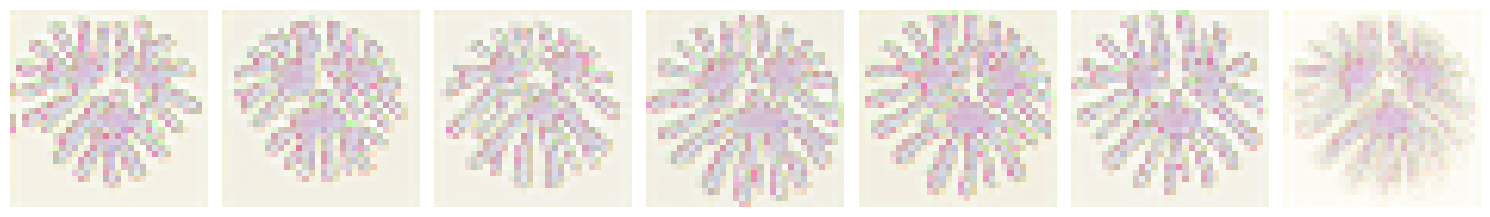

In [15]:
# Load 6 replicates


# load the SDVAE encoder and decoders 

import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from diffusers import AutoencoderKL
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


# Compute the average of the image and display

import re


# Use regex to find all replicate files matching the pattern
def get_replicate_paths(base_dir, base_name):
    """
    Finds all files matching the pattern for replicates of a given base name.
    Example base_name: "Fixed_19" (without the replicate number and extension)
    """
    pattern = os.path.join(base_dir, f"{base_name}_*.TIF")
    replicate_files = sorted(glob(pattern))
    return replicate_files

# Define the base name (e.g., "Fixed_19")
base_name = "Fixed_19"

# Get all replicate file paths
replicate_paths = get_replicate_paths(EXPERIMENTAL_FOLDER, base_name)
# Extract just the filenames from the full paths
replicate_filenames = [os.path.basename(path) for path in replicate_paths]


# Iterate over all replicate files and store processed images
decoded_images = []
latents=[]

# Use just the filenames, not the full paths
processed_images = preprocess_experimental_output_data_rawfiles(EXPERIMENTAL_FOLDER, 0, len(replicate_filenames), replicate_filenames)  # Pass just the filenames

print(f"Processed {len(processed_images)} images")


# convert to tensor
X=processed_images
X=(np.array(X).reshape(-1,1,256,256)) /255.0  

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)

for i in range(X.shape[0]):
    latent = encode_img(X[i].unsqueeze(0))  # Encode the image
    latents.append(latent.cpu().numpy())  # Store the latent representation
    decoded_image = decode_img(latent)  # Decode back to image space
    decoded_images.append(decoded_image[0].cpu().numpy())  # Collect decoded image as numpy array
    
# Stack images and calculate the average
decoded_images = np.stack(decoded_images, axis=0)  # Shape: (num_images, channels, height, width)
average_image = np.mean(decoded_images, axis=0)  # Average across the first dimension

# Stack latents and calculate the average
latents = np.stack(latents, axis=0)  # Shape: (num_images, channels, height, width)
average_latent = np.mean(latents, axis=0)  # Average across the first dimension

# Plot all images side by side
fig, axes = plt.subplots(1, len(decoded_images) + 1, figsize=(15, 5))

for i, img in enumerate(decoded_images):
    axes[i].imshow(np.transpose(img, (1, 2, 0)))  # Transpose to (height, width, channels) for plotting
    axes[i].axis("off")  # Turn off axes

# Plot the average image
axes[-1].imshow(np.transpose(average_image, (1, 2, 0)))
axes[-1].axis("off")  # Turn off axes

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

# Display all replicates' latents and the average
fig, axes = plt.subplots(1, len(replicate_paths) + 1, figsize=(15, 5))

# Plot each replicate's 4-channel latent
for i, latent in enumerate(latents):
    # Normalize latent for visualization
    latent = latent - latent.min()
    latent = latent / latent.max()

    # Permute dimensions for visualization
    latent_image = latent.squeeze(0).transpose(1, 2, 0)  # Shape: [H, W, 4]

    # Convert to PIL Image for display
    latent_pil = Image.fromarray((latent_image * 255).astype('uint8'))
    axes[i].imshow(latent_pil)
    axes[i].axis('off')

# 1. Save the unscaled average latent
average_latent_unscaled = average_latent.copy()

# Normalize the average latent for visualization
average_latent = average_latent - average_latent.min()
average_latent = average_latent / average_latent.max()

# Permute dimensions for visualization
average_latent_image = average_latent.squeeze(0).transpose(1, 2, 0)  # Shape: [H, W, 4]

# Convert the average latent to PIL Image for display
average_latent_pil = Image.fromarray((average_latent_image * 255).astype('uint8'))
axes[-1].imshow(average_latent_pil)
axes[-1].axis('off')

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()




average_latent_unscaled shape: (1, 4, 32, 32)


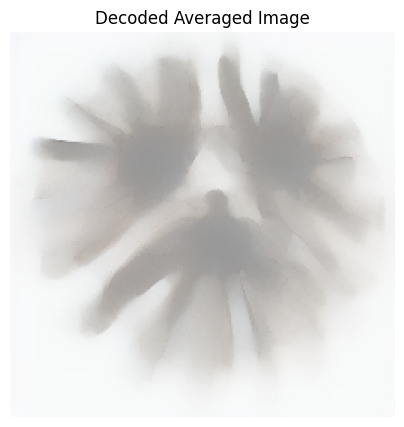

In [16]:
# Check the shape of average_latent_unscaled
print("average_latent_unscaled shape:", average_latent_unscaled.shape)

# Convert the unscaled average latent to a tensor without adding extra dimensions
if average_latent_unscaled.ndim == 3:
    # Shape is [4, 32, 32], add batch dimension
    average_latent_tensor = torch.from_numpy(average_latent_unscaled).float().unsqueeze(0).to(device)  # [1, 4, 32, 32]
elif average_latent_unscaled.ndim == 4 and average_latent_unscaled.shape[0] == 1:
    # Shape is already [1, 4, 32, 32], no need to unsqueeze
    average_latent_tensor = torch.from_numpy(average_latent_unscaled).float().to(device)  # [1, 4, 32, 32]
else:
    raise ValueError(f"Unexpected shape for average_latent_unscaled: {average_latent_unscaled.shape}")

# Decode the averaged latent
decoded_average_image = decode_img(average_latent_tensor)  # Expected shape: [1, 3, 256, 256]

# Prepare the decoded image for display
decoded_average_image = decoded_average_image.squeeze(0).cpu().numpy()  # [3, 256, 256]
decoded_average_image = np.transpose(decoded_average_image, (1, 2, 0))  # [256, 256, 3]
decoded_average_image = (decoded_average_image * 255).astype('uint8')  # [256, 256, 3]

# Display the decoded averaged image
plt.figure(figsize=(5, 5))
plt.imshow(decoded_average_image)
plt.axis('off')
plt.title("Decoded Averaged Image")
plt.show()
